## House Price Index Prediction

In [1]:
# Cell 1: Import necessary libraries and load the datasets
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline
import warnings
import tensorflow as tf
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# Set up visualization settings
warnings.filterwarnings("ignore")
sns.set(style="darkgrid", font_scale=1.5)
pd.set_option("display.max.columns", None)

# Load the datasets
current_dir = os.getcwd()
data_dir = "Group-7-Project-4/Data"
train_csv_path = os.path.join(current_dir, data_dir, "/content/train.csv")
test_csv_path = os.path.join(current_dir, data_dir, "/content/test.csv")

df_train = pd.read_csv(train_csv_path)
df_test = pd.read_csv(test_csv_path)


## Data Cleaning and Handling Missing Values

In [4]:
# Data Cleaning and Handling Missing Values
test_id = df_test["Id"]
df_train.drop(columns="Id", inplace=True)
df_test.drop(columns="Id", inplace=True)

# Check for missing values and drop columns with more than 45% missing values
cols_to_drop = ["FireplaceQu", "Fence", "Alley", "MiscFeature", "PoolQC"]
df_train.drop(columns=cols_to_drop, inplace=True)
df_test.drop(columns=cols_to_drop, inplace=True)

# Separate the target variable "SalePrice" from the train dataset
target = df_train[["SalePrice"]].reset_index(drop=True)
df_train.drop(columns=["SalePrice"], inplace=True)

# Concatenate the train and test datasets for data cleanup and analysis
df = pd.concat([df_train, df_test]).reset_index(drop=True)

# Handling Missing Values for Garage-related Features
garage_cols = ["GarageYrBlt", "GarageArea", "GarageCars", "GarageType", "GarageFinish", "GarageQual", "GarageCond"]
for col in garage_cols:
    if df[col].dtype == "object":
        df[col].fillna("None", inplace=True)
    else:
        df[col].fillna(0, inplace=True)

# Handling Missing Values for Basement-related Features
basement_cols = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]
for col in basement_cols:
    df[col].fillna("None", inplace=True)

# Handling Missing Values for Other Categorical Features
df['MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
cat_cols = ['Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Electrical', 'KitchenQual', 'Functional', 'SaleType']
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Handling Missing Values for LotFrontage
df["LotFrontage"] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Handling Missing Values for MasVnrArea, BsmtFinSF1, and BsmtFinSF2
df["MasVnrArea"] = df.groupby("MasVnrType")["MasVnrArea"].transform(lambda x: x.fillna(x.median()))
df["BsmtFinSF1"] = df.groupby("BsmtFinType1")["BsmtFinSF1"].transform(lambda x: x.fillna(x.median()))
df["BsmtFinSF2"] = df.groupby("BsmtFinType2")["BsmtFinSF2"].transform(lambda x: x.fillna(x.median()))

# Handling Missing Values for BsmtFullBath and BsmtHalfBath
df["BsmtFullBath"].fillna(0, inplace=True)
df["BsmtHalfBath"].fillna(0, inplace=True)

# Creating a new feature 'TotalBsmtSF'
df["TotalBsmtSF"] = df["BsmtFinSF1"] + df["BsmtFinSF2"]

# Handling Missing Values for BsmtUnfSF
df["BsmtUnfSF"].fillna(df["BsmtUnfSF"].median(), inplace=True)

# Check if there are any missing values left
print("Total Missing Values Left is:", df.isnull().sum().sum())

# Separate the train and test datasets after data cleanup
df_train_cleaned = df.iloc[:len(df_train)].copy()
df_test_cleaned = df.iloc[len(df_train):].copy()


Total Missing Values Left is: 0


## Data Analysis and Visualization

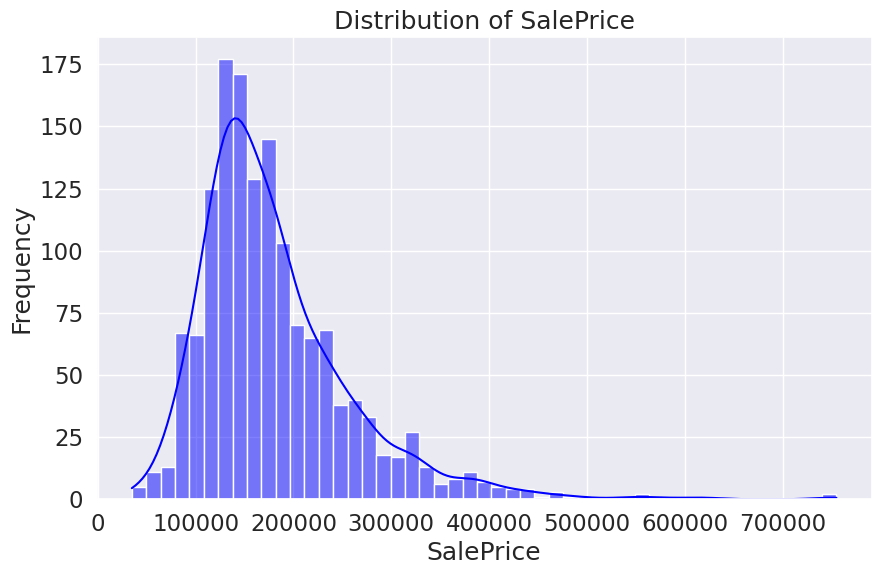

In [5]:
# Visualize the distribution of the target variable "SalePrice"
plt.figure(figsize=(10, 6))
sns.histplot(target["SalePrice"], kde=True, color="blue")
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()


In [6]:
# Check the skewness of the target variable "SalePrice"
print("Skewness of SalePrice:", target["SalePrice"].skew())

# Log-transform the target variable "SalePrice" to reduce skewness
target["SalePrice"] = np.log1p(target["SalePrice"])

# Check the skewness of the log-transformed target variable "SalePrice"
print("Skewness of log-transformed SalePrice:", target["SalePrice"].skew())


Skewness of SalePrice: 1.8828757597682129
Skewness of log-transformed SalePrice: 0.12134661989685333


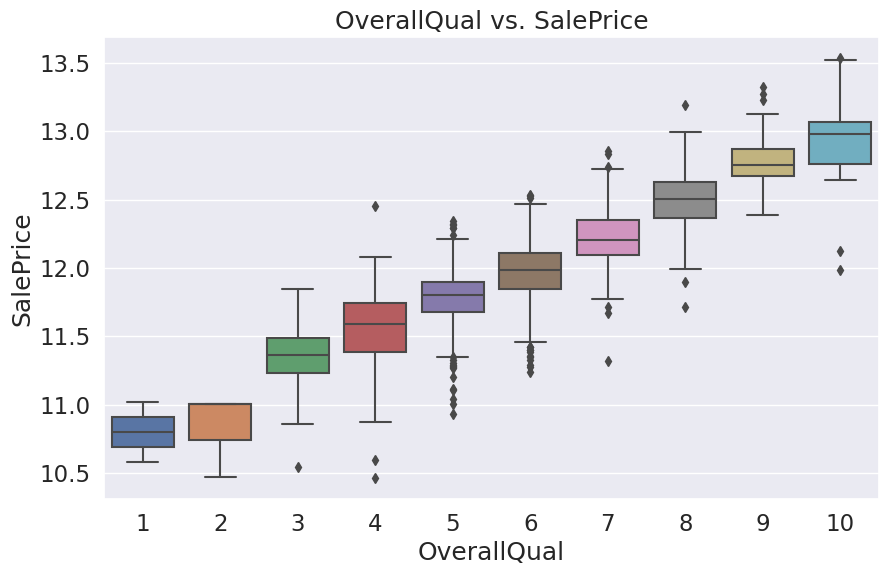

In [7]:
# Visualize the relationship between the overall quality ('OverallQual') and the sale price
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_train_cleaned["OverallQual"], y=target["SalePrice"])
plt.title("OverallQual vs. SalePrice")
plt.show()


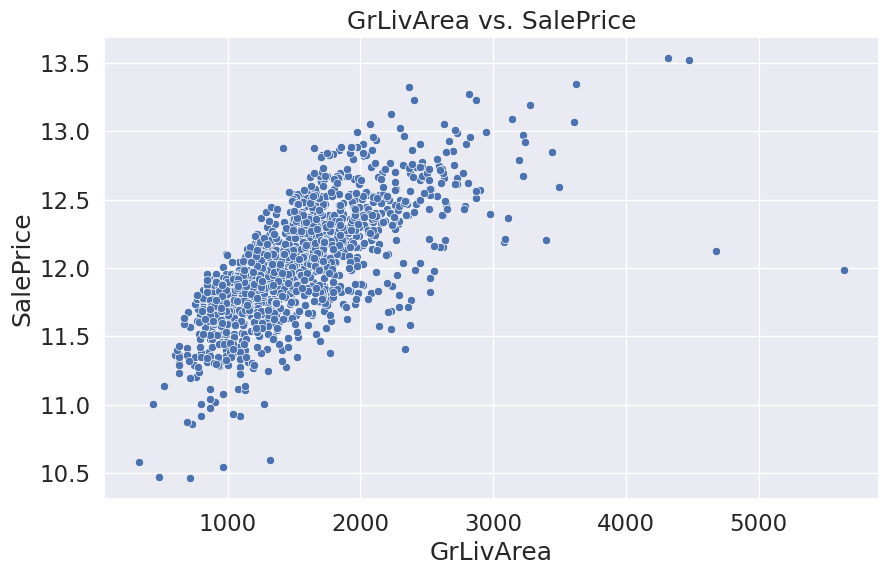

In [8]:
# Visualize the relationship between the above-ground living area square feet ('GrLivArea') and the sale price
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_train_cleaned["GrLivArea"], y=target["SalePrice"])
plt.title("GrLivArea vs. SalePrice")
plt.show()


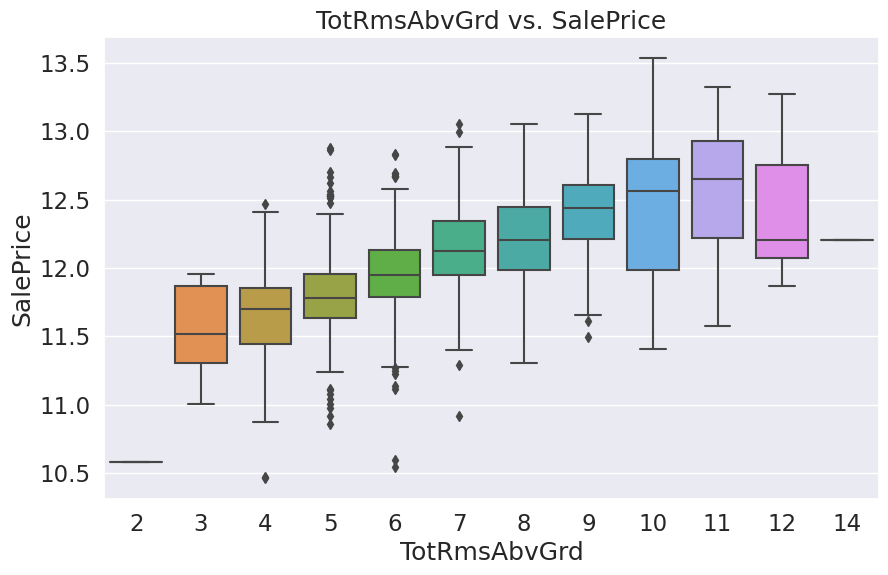

In [9]:
# Visualize the relationship between the total rooms above ground ('TotRmsAbvGrd') and the sale price
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_train_cleaned["TotRmsAbvGrd"], y=target["SalePrice"])
plt.title("TotRmsAbvGrd vs. SalePrice")
plt.show()


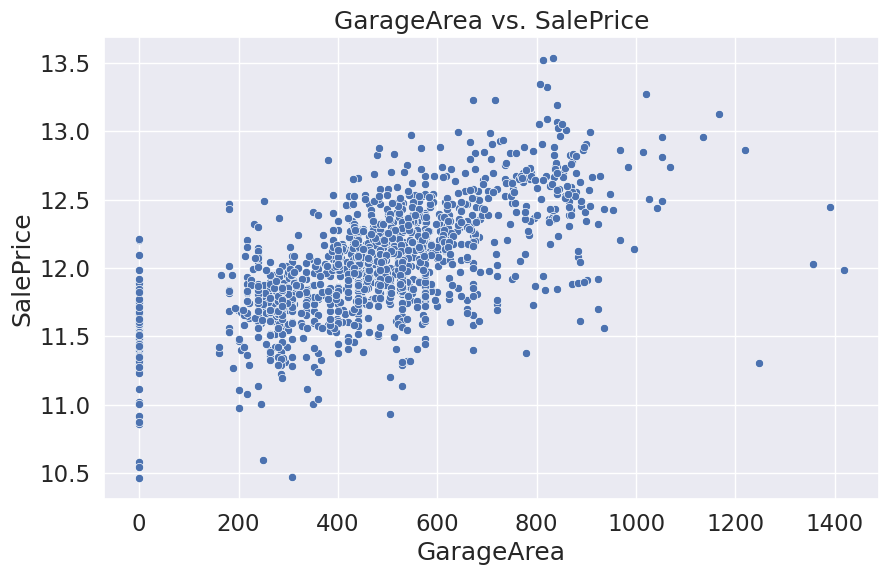

In [10]:
# Visualize the relationship between the garage area ('GarageArea') and the sale price
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_train_cleaned["GarageArea"], y=target["SalePrice"])
plt.title("GarageArea vs. SalePrice")
plt.show()


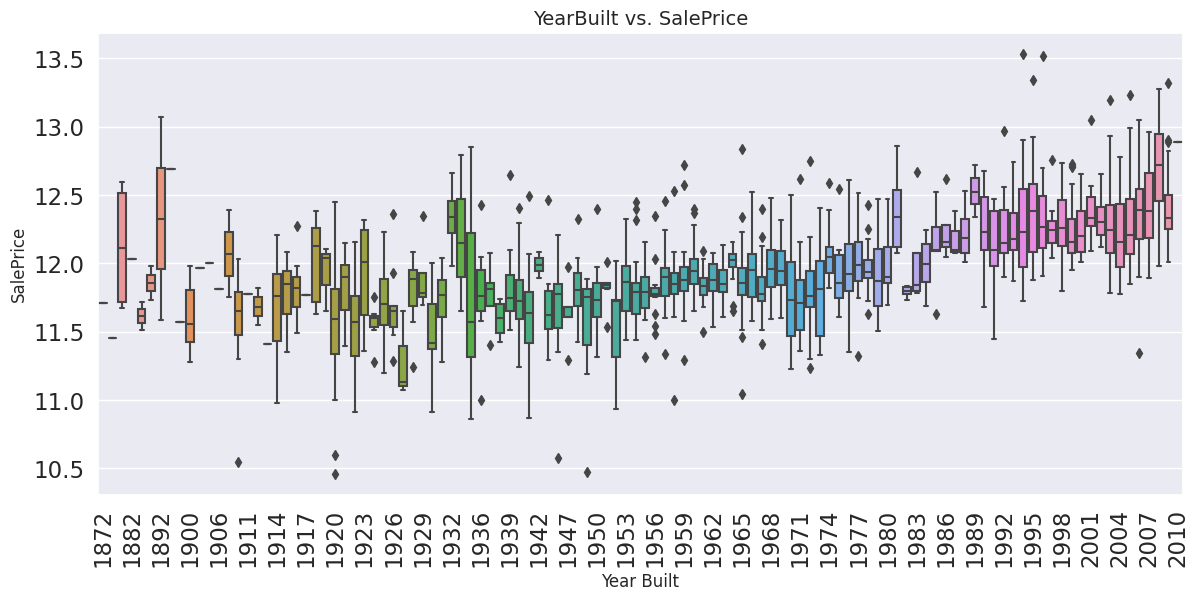

In [25]:
# Visualize the relationship between the year built ('YearBuilt') and the sale price
plt.figure(figsize=(14, 6))
sns.boxplot(x=df_train_cleaned["YearBuilt"], y=target["SalePrice"])
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(75))  # Limit the number of x-axis ticks to 75
plt.xlabel("Year Built", fontsize=12)  # Set x-axis label and font size
plt.ylabel("SalePrice", fontsize=12)  # Set y-axis label and font size
plt.title("YearBuilt vs. SalePrice", fontsize=14)  # Set plot title and font size
plt.show()


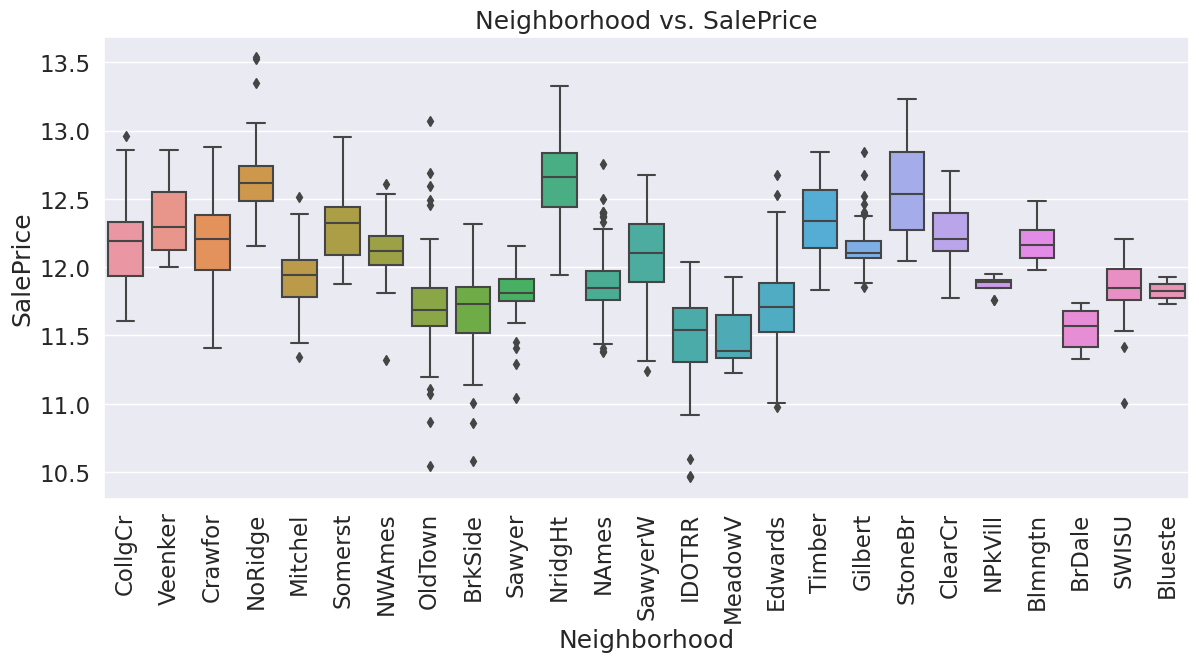

In [12]:
# Visualize the relationship between the neighborhood ('Neighborhood') and the sale price
plt.figure(figsize=(14, 6))
sns.boxplot(x=df_train_cleaned["Neighborhood"], y=target["SalePrice"])
plt.xticks(rotation=90)
plt.title("Neighborhood vs. SalePrice")
plt.show()


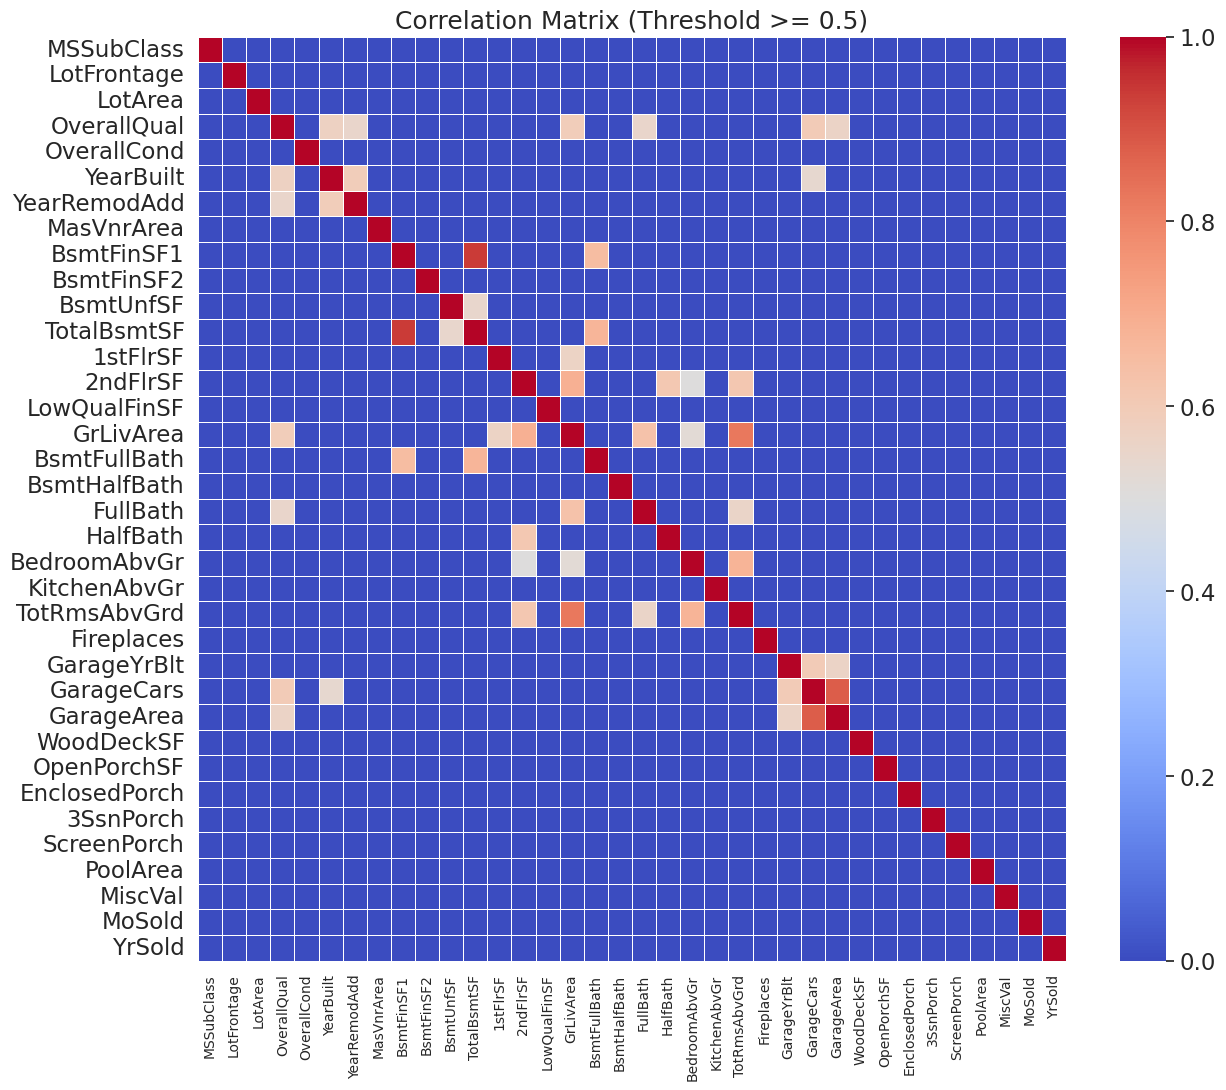

In [18]:
# Calculate the correlation matrix
correlation_matrix = df_train_cleaned.corr()

# Increase the size of the figure
plt.figure(figsize=(14, 12))

# Set a correlation threshold for display (e.g., 0.5)
threshold = 0.5
correlation_matrix_masked = correlation_matrix.abs()
correlation_matrix_masked[correlation_matrix_masked < threshold] = 0

# Plot the heatmap without numeric annotations
sns.heatmap(correlation_matrix_masked, cmap="coolwarm", annot=False, fmt=".2f", linewidths=0.5)

# Set x-axis labels to be displayed vertically and set font size for better readability
plt.xticks(rotation=90, fontsize=10)

plt.title("Correlation Matrix (Threshold >= 0.5)")
plt.show()


## Train and Evaluate the Scikit-learn Linear Regression Model

In [26]:
# Assuming 'df_train_cleaned' is the cleaned train dataset and 'target' is the target variable
# Separate the features and target variable
X = df_train_cleaned.copy()  # No need to drop the target variable from the features
y = target["SalePrice"]

# Perform one-hot encoding on categorical columns
X = pd.get_dummies(X, drop_first=True)  # Use drop_first=True to avoid multicollinearity

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Scikit-learn Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the Scikit-learn Linear Regression model
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
print("Scikit-learn Linear Regression Model - Mean Squared Error:", mse)
print("Scikit-learn Linear Regression Model - R-squared:", r_squared)


Scikit-learn Linear Regression Model - Mean Squared Error: 0.04385514017016819
Scikit-learn Linear Regression Model - R-squared: 0.7649916518756069


## Train and Evaluate the TensorFlow Model

In [27]:
# Create the TensorFlow model
tf_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer with no activation function for regression
])
# Compile the model
tf_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the TensorFlow model
tf_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the TensorFlow model
tf_y_pred = tf_model.predict(X_test)
tf_mse = mean_squared_error(y_test, tf_y_pred)
tf_r_squared = r2_score(y_test, tf_y_pred)
print("TensorFlow Model - Mean Squared Error:", tf_mse)
print("TensorFlow Model - R-squared:", tf_r_squared)


Epoch 1/100
30/30 [==============================] - 4s 23ms/step - loss: 18205.8789 - val_loss: 26709.3008
Epoch 2/100
30/30 [==============================] - 0s 6ms/step - loss: 132315.8906 - val_loss: 11071.5205
Epoch 3/100
30/30 [==============================] - 0s 11ms/step - loss: 19038.4727 - val_loss: 4711.6025
Epoch 4/100
30/30 [==============================] - 0s 9ms/step - loss: 4028.3787 - val_loss: 760.8052
Epoch 5/100
30/30 [==============================] - 0s 8ms/step - loss: 3214.5901 - val_loss: 2804.7891
Epoch 6/100
30/30 [==============================] - 0s 8ms/step - loss: 1373.0238 - val_loss: 961.8034
Epoch 7/100
30/30 [==============================] - 0s 9ms/step - loss: 973.8627 - val_loss: 362.1016
Epoch 8/100
30/30 [==============================] - 0s 10ms/step - loss: 892.3270 - val_loss: 1193.7590
Epoch 9/100
30/30 [==============================] - 0s 10ms/step - loss: 1268.7528 - val_loss: 134.2934
Epoch 10/100
30/30 [==============================]

## Train and Evaluate the Keras Model

In [28]:
# Create the Keras model (same architecture as TensorFlow model)
keras_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer with no activation function for regression
])
# Compile the model
keras_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the Keras model
keras_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the Keras model
keras_y_pred = keras_model.predict(X_test)
keras_mse = mean_squared_error(y_test, keras_y_pred)
keras_r_squared = r2_score(y_test, keras_y_pred)
print("Keras Model - Mean Squared Error:", keras_mse)
print("Keras Model - R-squared:", keras_r_squared)


Epoch 1/100
30/30 [==============================] - 1s 9ms/step - loss: 353607.6250 - val_loss: 19199.6309
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 9773.2236 - val_loss: 2518.3491
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 2768.8386 - val_loss: 2152.0833
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 1606.9227 - val_loss: 1336.2596
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 1386.9790 - val_loss: 938.1494
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 1471.1202 - val_loss: 442.6314
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 911.9905 - val_loss: 474.3815
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 513.2241 - val_loss: 521.1462
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 609.0532 - val_loss: 245.7092
Epoch 10/100
30/30 [==============================] - 0s 4ms

## Train and Evaluate the XGBoost Model

In [29]:
# Create and train the XGBoost model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
xgb_y_pred = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_y_pred)
xgb_r_squared = r2_score(y_test, xgb_y_pred)
print("XGBoost Model - Mean Squared Error:", xgb_mse)
print("XGBoost Model - R-squared:", xgb_r_squared)


XGBoost Model - Mean Squared Error: 0.024745890649137327
XGBoost Model - R-squared: 0.8673931753095494


## Compare model performances

In [30]:
# Compare model performances
print("Scikit-learn Linear Regression Model - Mean Squared Error:", mse)
print("Scikit-learn Linear Regression Model - R-squared:", r_squared)

print("TensorFlow Model - Mean Squared Error:", tf_mse)
print("TensorFlow Model - R-squared:", tf_r_squared)

print("Keras Model - Mean Squared Error:", keras_mse)
print("Keras Model - R-squared:", keras_r_squared)

print("XGBoost Model - Mean Squared Error:", xgb_mse)
print("XGBoost Model - R-squared:", xgb_r_squared)


Scikit-learn Linear Regression Model - Mean Squared Error: 0.04385514017016819
Scikit-learn Linear Regression Model - R-squared: 0.7649916518756069
TensorFlow Model - Mean Squared Error: 22.94639813991403
TensorFlow Model - R-squared: -121.96380997395775
Keras Model - Mean Squared Error: 40.008884966047745
Keras Model - R-squared: -213.3972617505303
XGBoost Model - Mean Squared Error: 0.024745890649137327
XGBoost Model - R-squared: 0.8673931753095494
